In [14]:
import os
import re
import gensim
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import matplotlib.pyplot as plt

import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display
import pyLDAvis.gensim_models as gensimvis

# Ensure NLTK dependencies are available
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(file_path):
    """Read and preprocess text from a file."""
    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    
    # Tokenize and clean each line
    processed_lines = []
    for line in lines:
        tokens = word_tokenize(line.lower())
        tokens = [re.sub(r'[^a-z]', '', token) for token in tokens]  # Remove non-alphabetical characters
        tokens = [lemmatizer.lemmatize(token) for token in tokens if token and token not in stop_words]  # Lemmatize tokens and remove stopwords
        processed_lines.append(tokens)

    return processed_lines

def lda_topic_modeling(processed_lines, num_topics=3):
    """Perform LDA topic modeling on tokenized lines."""
    # Create a dictionary representation of the documents.
    dictionary = corpora.Dictionary(processed_lines)

    # Create a document-term matrix.
    corpus = [dictionary.doc2bow(text) for text in processed_lines]

    # Perform LDA topic modeling.
    lda_model = gensim.models.LdaModel(
        corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=10,
        random_state=493
    )

    # Print topics
    topics = lda_model.print_topics()
    for idx, topic in topics:
        print(f"Topic {idx}: {topic}")

    return lda_model

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dd\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# File path
file_path = "../../data/txt/cleaned_contents.txt"  # Replace with your .txt file path

# Ensure the file exists
if not os.path.exists(file_path):
    print(f"File not found: {file_path}")
else:
    # Preprocess text
    processed_lines = preprocess_text(file_path)

    # Perform LDA topic modeling
    lda_model = lda_topic_modeling(processed_lines, num_topics=3)

Topic 0: 0.044*"republic" + 0.040*"first" + 0.037*"deposit" + 0.030*"bank" + 0.024*"loan" + 0.015*"rate" + 0.014*"asset" + 0.011*"interest" + 0.010*"uninsured" + 0.010*"large"
Topic 1: 0.059*"fdic" + 0.034*"review" + 0.028*"examination" + 0.026*"report" + 0.017*"loss" + 0.015*"material" + 0.012*"supervision" + 0.011*"recommendation" + 0.011*"failure" + 0.010*"bank"
Topic 2: 0.037*"risk" + 0.034*"management" + 0.020*"bank" + 0.019*"action" + 0.016*"rating" + 0.015*"institution" + 0.014*"liquidity" + 0.011*"examiner" + 0.011*"capital" + 0.010*"financial"


In [3]:
# Print the topics
topics = lda_model.print_topics(num_words=7)  # num_words shows top words in each topic
for topic in topics:
    print(topic)

(0, '0.044*"republic" + 0.040*"first" + 0.037*"deposit" + 0.030*"bank" + 0.024*"loan" + 0.015*"rate" + 0.014*"asset"')
(1, '0.059*"fdic" + 0.034*"review" + 0.028*"examination" + 0.026*"report" + 0.017*"loss" + 0.015*"material" + 0.012*"supervision"')
(2, '0.037*"risk" + 0.034*"management" + 0.020*"bank" + 0.019*"action" + 0.016*"rating" + 0.015*"institution" + 0.014*"liquidity"')


In [4]:
def compute_coherence_scores(processed_lines, start=2, limit=6):
    """Compute coherence scores for various numbers of topics."""
    dictionary = corpora.Dictionary(processed_lines)
    corpus = [dictionary.doc2bow(text) for text in processed_lines]

    coherence_scores = []
    for num_topics in range(start, limit + 1):
        lda_model = gensim.models.LdaModel(
            corpus,
            num_topics=num_topics,
            id2word=dictionary,
            passes=10,
            random_state=493
        )
        coherence_model = CoherenceModel(model=lda_model, texts=processed_lines, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append((num_topics, coherence_score))
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

    return coherence_scores

In [5]:
# Compute coherence scores
coherence_scores = compute_coherence_scores(processed_lines, start=2, limit=6)

Number of Topics: 2, Coherence Score: 0.5009388950323422
Number of Topics: 3, Coherence Score: 0.4402835498126388
Number of Topics: 4, Coherence Score: 0.4090450571482522
Number of Topics: 5, Coherence Score: 0.38161108960622353
Number of Topics: 6, Coherence Score: 0.3739312139389906


In [6]:
def plot_coherence_scores(coherence_scores):
    """Plot coherence scores for different numbers of topics."""
    num_topics = [score[0] for score in coherence_scores]
    scores = [score[1] for score in coherence_scores]

    plt.figure(figsize=(8, 5))
    plt.plot(num_topics, scores, marker='o', linestyle='--', color='b')
    plt.title('Coherence Scores by Number of Topics')
    plt.xlabel('Number of Topics')
    plt.ylabel('Coherence Score')
    plt.grid()
    plt.show()

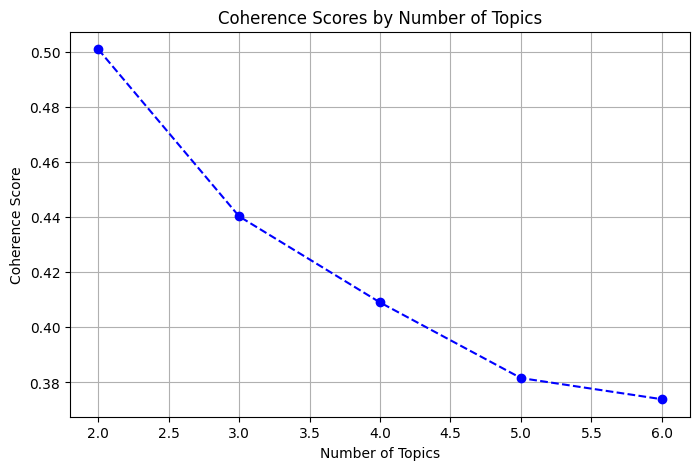

In [7]:
# Plot coherence scores
plot_coherence_scores(coherence_scores)

In [9]:
def show_pyldavis_inline(lda_model, corpus, dictionary):
    """Display pyLDAvis visualization inline in a Jupyter Notebook."""
    pyLDAvis.enable_notebook()
    vis = gensimvis.prepare(lda_model, corpus, dictionary)
    return vis

In [13]:
dictionary = corpora.Dictionary(processed_lines)
corpus = [dictionary.doc2bow(text) for text in processed_lines]
vis = show_pyldavis_inline(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.111719 -0.295910       1        1  34.705218
0     -0.324542  0.055675       2        1  32.908447
1      0.212823  0.240235       3        1  32.386335, topic_info=             Term          Freq         Total Category  logprob  loglift
140          fdic  14519.000000  14519.000000  Default  30.0000  30.0000
6715     republic  11395.000000  11395.000000  Default  29.0000  29.0000
31           risk   9764.000000   9764.000000  Default  28.0000  28.0000
246       deposit   9274.000000   9274.000000  Default  27.0000  27.0000
22     management   9003.000000   9003.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
53    institution   1945.074931   5913.071657   Topic3  -4.8375   0.0156
10           bank   2508.909226  15330.572822   Topic3  -4.5830  -0.6826
5           first   2121.020622  12086.429061   Topic3  -4.7509  -0.6128
185        policy   1360.017343   2095.691697   Topic3  -5.1953   0.6950
388        system   1296.415112   2026.962097   Topic3  -5.2432   0.6805

[154 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
251       1  0.000648     act
251       2  0.000648     act
251       3  0.998935     act
56        1  0.999580  action
56        2  0.000203  action
...     ...       ...     ...
159       2  0.000944   would
159       3  0.000944   would
5835      1  0.001001    york
5835      2  0.998212    york
5835      3  0.001001    york

[348 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])